In [1]:
import scanpy as sc
import decoupler as dc

# Only needed for processing
import numpy as np
import pandas as pd
from anndata import AnnData

# 1. DESeq2

In [2]:
path_deseq2 = "/tscc/nfs/home/aklie/scratch/differential_analysis/deseq2_results.csv"
path_out = '/tscc/nfs/home/aklie/scratch/functional_analysis'

In [3]:
%%bash 
mkdir -p path_out

In [4]:
res = pd.read_csv(path_deseq2, index_col=0)
res.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ensembl_gene_id,Symbol
Geneid,,,,,,,,
ENSG00000227232.4,35.027741,1.337082,0.410239,3.259280,0.001117,0.002536,ENSG00000227232,WASH7P
ENSG00000237683.5,59.995128,0.842590,0.296633,2.840513,0.004504,0.009338,ENSG00000237683,NaN
ENSG00000241860.2,28.423092,1.178053,0.438898,2.684118,0.007272,0.014624,ENSG00000241860,AL627309.5
ENSG00000237094.7,87.465975,0.425554,0.239653,1.775712,0.075780,0.122687,ENSG00000237094,NaN
ENSG00000225972.1,46.995998,-0.774459,0.309139,-2.505212,0.012238,0.023611,ENSG00000225972,MTND1P23


/tscc/nfs/home/aklie/opt/miniconda3/envs/2024-mstp-bootcamp/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


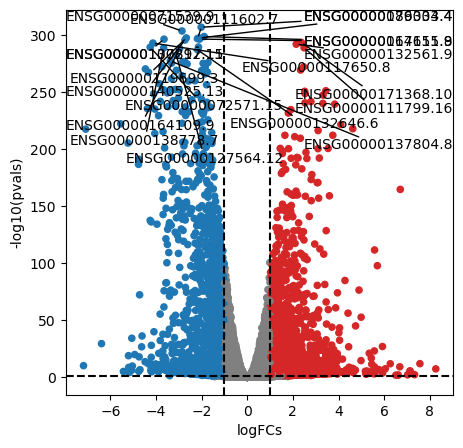

In [5]:
dc.plot_volcano_df(
    res,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(5, 5),
    sign_thr=0.05,
    lFCs_thr=1,
)

## 1a. Run a pathway analysis with PROGENy as the model

In [6]:
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

/tscc/nfs/home/aklie/opt/miniconda3/envs/2024-mstp-bootcamp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


In [7]:
res.set_index("Symbol", inplace=True)

In [8]:
res = res[~res.index.isna()]

In [9]:
res = res[~res.index.duplicated()]

In [10]:
mat = res[['stat']].T.rename(index={'stat': 'Persister.vs.Parental'})
mat

Symbol,WASH7P,AL627309.5,MTND1P23,MTND2P28,MTCO1P12,MTCO2P12,MTATP8P1,MTATP6P1,MTCO3P12,LINC01409,...,MT-ND4L,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-CYB,MT-TT,MT-TP
Persister.vs.Parental,3.25928,2.684118,-2.505212,-1.74262,5.878026,0.999432,-0.654318,-0.364198,-9.321077,2.853013,...,-0.696448,1.972445,-2.874314,-2.669273,-1.866504,15.830037,20.610859,8.277646,-6.390608,7.511151


In [11]:
# Infer TF activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts

Running ulm on mat with 1 samples and 17007 targets for 647 sources.


,ABL1,AHR,AHRR,AIP,AIRE,AP1,APEX1,AR,ARID1A,ARID3A,...,ZNF350,ZNF354C,ZNF362,ZNF382,ZNF384,ZNF395,ZNF699,ZNF76,ZNF804A,ZNF91
Persister.vs.Parental,0.224873,-0.509236,2.708392,-1.3391,0.514388,-2.230843,-2.113818,-2.178642,0.1139,-3.954774,...,-0.003172,0.169539,-0.398154,-1.661815,0.552742,-0.222977,-0.778043,-1.343416,0.426689,0.102398


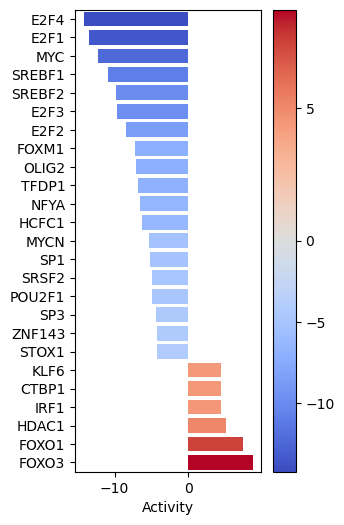

In [12]:
dc.plot_barplot(
    acts=tf_acts,
    contrast='Persister.vs.Parental',
    top=25,
    vertical=True,
    figsize=(3, 6)
)

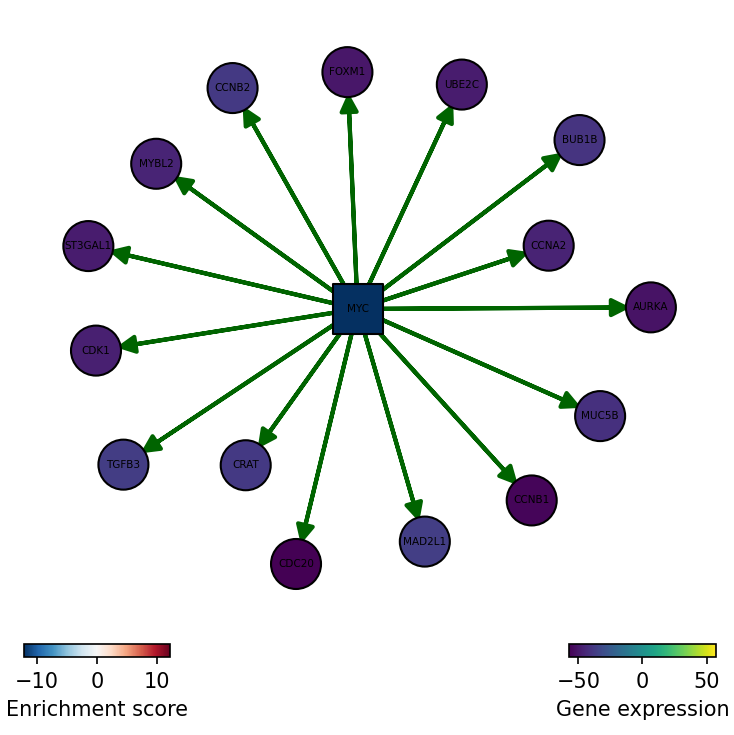

In [13]:
dc.plot_network(
    net=collectri,
    obs=mat,
    act=tf_acts,
    n_sources=['MYC'],
    n_targets=15,
    node_size=50,
    figsize=(5, 5),
    c_pos_w='darkgreen',
    c_neg_w='darkred',
    vcenter=True
)

/tscc/nfs/home/aklie/opt/miniconda3/envs/2024-mstp-bootcamp/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


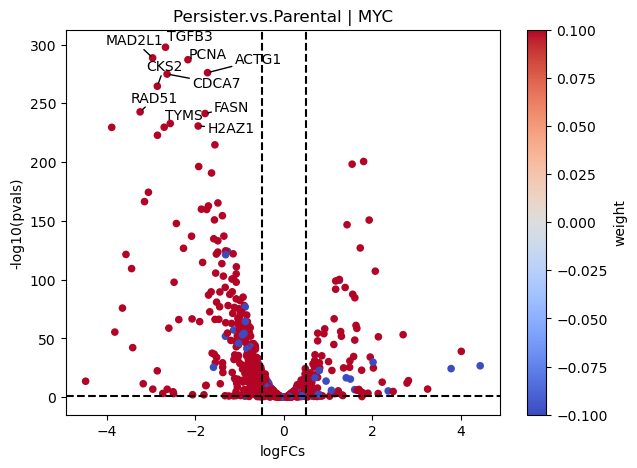

In [14]:
# Extract logFCs and pvals
logFCs = res[['log2FoldChange']].T.rename(index={'log2FoldChange': 'Persister.vs.Parental'})
pvals = res[['padj']].T.rename(index={'padj': 'Persister.vs.Parental'})

# Plot
dc.plot_volcano(
    logFCs,
    pvals,
    'Persister.vs.Parental',
    name='MYC',
    net=collectri,
    top=10,
    sign_thr=0.05,
    lFCs_thr=0.5
)

In [15]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=500)
progeny

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
6995,p53,ZMYM4,-2.325752,1.522388e-06
6996,p53,CFDP1,-1.628168,1.526045e-06
6997,p53,VPS37D,2.309503,1.537098e-06
6998,p53,TEDC1,-2.274823,1.547037e-06


In [16]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny, verbose=True)
pathway_acts

Running mlm on mat with 1 samples and 17007 targets for 14 sources.


,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
Persister.vs.Parental,-2.814406,-6.663426,0.677134,6.390394,0.116835,-12.904999,1.167528,-12.271215,2.908719,0.027806,2.886794,-1.770708,0.012269,11.876383


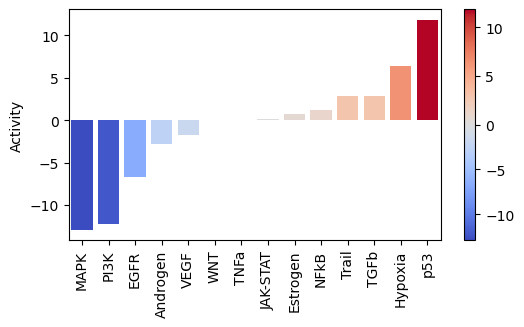

In [17]:
dc.plot_barplot(
    pathway_acts,
    'Persister.vs.Parental',
    top=25,
    vertical=False,
    figsize=(6, 3)
)

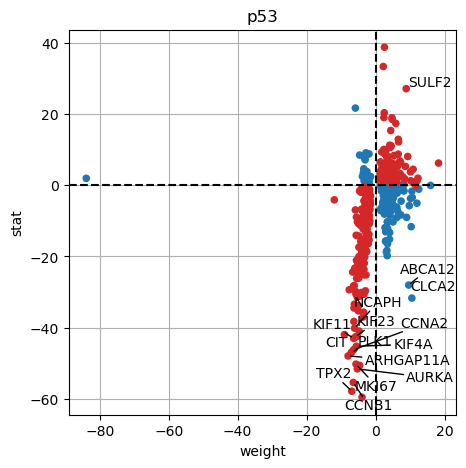

In [18]:
dc.plot_targets(res, stat='stat', source_name='p53', net=progeny, top=15)

In [19]:
msigdb = dc.get_resource('MSigDB')
msigdb

,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP
...,...,...,...
3838543,PRAMEF22,go_biological_process,GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...
3838544,PRAMEF22,go_biological_process,GOBP_APOPTOTIC_PROCESS
3838545,PRAMEF22,go_biological_process,GOBP_REGULATION_OF_CELL_DEATH
3838546,PRAMEF22,go_biological_process,GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS


In [20]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

# Rename
msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in msigdb['geneset']]

msigdb

/tmp/ipykernel_2077225/2098377670.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['IL2_STAT5_SIGNALING', 'COAGULATION', 'HYPOXIA', 'TNFA_SIGNALING_VIA_NFKB', 'COMPLEMENT', 'HYPOXIA', 'P53_PATHWAY', 'TNFA_SIGNALING_VIA_NFKB', 'GLYCOLYSIS', 'APOPTOSIS', 'IL2_STAT5_SIGNALING', 'TNFA_SIGNALING_VIA_NFKB', 'TNFA_SIGNALING_VIA_NFKB', 'EPITHELIAL_MESENCHYMAL_TRANSITION', 'IL2_STAT5_SIGNALING', 'TNFA_SIGNALING_VIA_NFKB', 'TNFA_SIGNALING_VIA_NFKB', 'PROTEIN_SECRETION', 'ADIPOGENESIS', 'BILE_ACID_METABOLISM', 'INFLAMMATORY_RESPONSE', 'INFLAMMATORY_RESPONSE', 'TNFA_SIGNALING_VIA_NFKB', 'UNFOLDED_PROTEIN_RESPONSE', 'TNFA_SIGNALING_VIA_NFKB', 'IL2_STAT5_SIGNALING', 'P53_PATHWAY', 'TNFA_SIGNALING_VIA_NFKB', 'TGF_BETA_SIGNALING', 'KRAS_SIGNALING_UP', 'UV_RESPONSE_UP', 'APOPTOSIS', 'TNFA_SIGNALING_VIA_NFKB', 'APOPTOSIS', 'ALLOGRAFT_REJECTION', 'INTERFERON_GAMMA_RESPONSE', 'INTERFERON_ALPHA_RESPONSE', 'TNFA_SIGNALING_VIA_NFKB',

,genesymbol,collection,geneset
233,MAFF,hallmark,IL2_STAT5_SIGNALING
250,MAFF,hallmark,COAGULATION
270,MAFF,hallmark,HYPOXIA
373,MAFF,hallmark,TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,COMPLEMENT
...,...,...,...
1449668,STXBP1,hallmark,PANCREAS_BETA_CELLS
1450315,ELP4,hallmark,PANCREAS_BETA_CELLS
1450526,GCG,hallmark,PANCREAS_BETA_CELLS
1450731,PCSK2,hallmark,PANCREAS_BETA_CELLS


In [21]:
# Infer enrichment with ora using significant deg
top_genes = res[res['padj'] < 0.05]

# Run ora
enr_pvals = dc.get_ora_df(
    df=top_genes,
    net=msigdb,
    source='geneset',
    target='genesymbol'
)

enr_pvals.head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,ADIPOGENESIS,200,0.730000,2.014553e-06,7.194831e-06,1.283906,1.683858e+01,ABCA1;ABCB8;ACADL;ACLY;ACO2;ACOX1;ADCY6;ADIPOR...
1,ALLOGRAFT_REJECTION,200,0.350000,1.000000e+00,1.000000e+00,0.613713,5.361270e-11,AARS1;ABCE1;ACHE;ACVR2A;AKT1;APBB1;B2M;BCL10;B...
2,ANDROGEN_RESPONSE,100,0.840000,7.604226e-09,3.456466e-08,1.476745,2.760710e+01,ABCC4;ACSL3;ACTN1;ADAMTS1;ADRM1;AKAP12;AKT1;AN...
3,ANGIOGENESIS,36,0.555556,6.400262e-01,8.649003e-01,0.984066,4.391356e-01,APP;CCND2;COL5A2;FGFR1;FSTL1;JAG1;JAG2;LRPAP1;...
4,APICAL_JUNCTION,200,0.585000,3.685219e-01,5.419440e-01,1.027111,1.025319e+00,ACTB;ACTG1;ACTN1;ACTN4;ADAM15;ADAM9;AKT2;AKT3;...


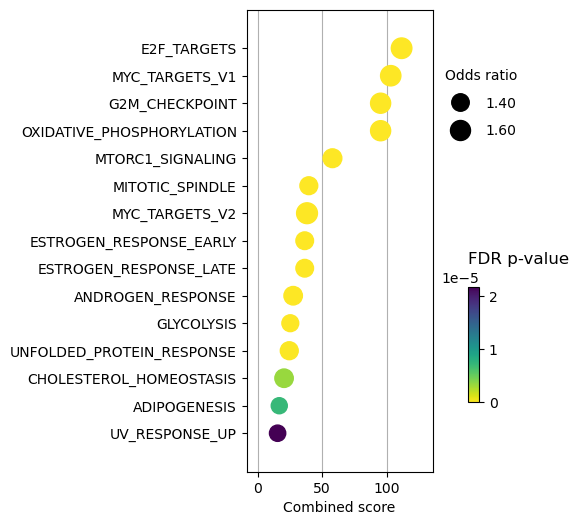

In [22]:
dc.plot_dotplot(
    enr_pvals.sort_values('Combined score', ascending=False).head(15),
    x='Combined score',
    y='Term',
    s='Odds ratio',
    c='FDR p-value',
    scale=1.5,
    figsize=(3, 6)
)

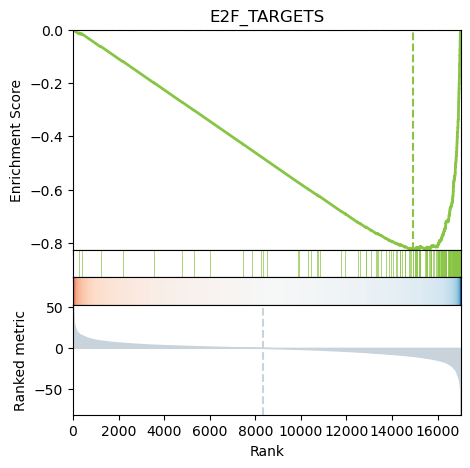

In [23]:
# Plot
dc.plot_running_score(
    df=res,
    stat='stat',
    net=msigdb,
    source='geneset',
    target='genesymbol',
    set_name='E2F_TARGETS'
)

In [24]:
import liana as ln

In [25]:
liana_lr = ln.resource.select_resource()
liana_lr = ln.resource.explode_complexes(liana_lr)

# Create two new DataFrames, each containing one of the pairs of columns to be concatenated
df1 = liana_lr[['interaction', 'ligand']]
df2 = liana_lr[['interaction', 'receptor']]

# Rename the columns in each new DataFrame
df1.columns = ['interaction', 'genes']
df2.columns = ['interaction', 'genes']

# Concatenate the two new DataFrames
liana_lr = pd.concat([df1, df2], axis=0)
liana_lr['weight'] = 1

# Find duplicated rows
duplicates = liana_lr.duplicated()

# Remove duplicated rows
liana_lr = liana_lr[~duplicates]

liana_lr

,interaction,genes,weight
0,LGALS9&PTPRC,LGALS9,1
1,LGALS9&MET,LGALS9,1
2,LGALS9&CD44,LGALS9,1
3,LGALS9&LRP1,LGALS9,1
4,LGALS9&CD47,LGALS9,1
...,...,...,...
5775,BMP2&ACTR2,ACTR2,1
5776,BMP15&ACTR2,ACTR2,1
5777,CSF1&CSF3R,CSF3R,1
5778,IL36G&IFNAR1,IFNAR1,1


In [26]:
# Infer lr activities with ulm
lr_score, lr_pvalue = dc.run_ulm(
    mat=mat,
    net=liana_lr,
    source='interaction',
    target='genes',
    min_n=2,
    verbose=True
)

Running ulm on mat with 1 samples and 17007 targets for 2022 sources.


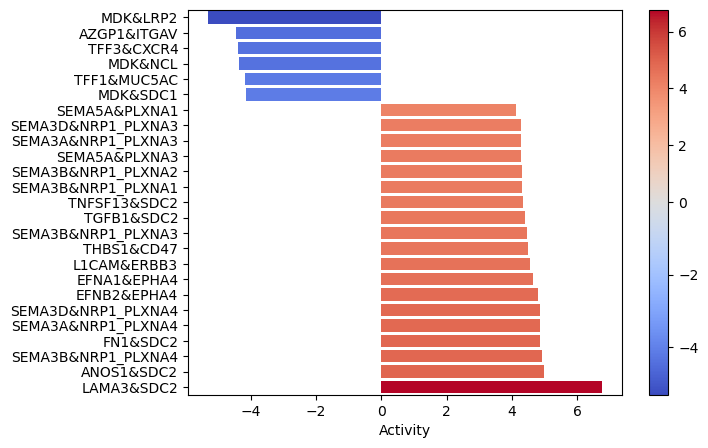

In [28]:
dc.plot_barplot(lr_score, 'Persister.vs.Parental', top=25, vertical=True)

# DONE!

---